In [1]:
import os
import h5py
import image
import operator

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from PIL import Image
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D ,Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import applications


%matplotlib inline

Using TensorFlow backend.


In [2]:
class_name = {
    2: 'Top',
    1: 'Outer',
    0: 'Bottom'}
nb_classes=3
# class_pattern = {
#     0: 'Checked',
#     1: 'Carmo',
#     2: 'Striped',
#     3: 'Plain',}
# nb_classes=4
# class_color = {
#     0: 'Black',
#     1: 'Blue',
#     2: 'Green',
#     3: 'Red',
#     4: 'White'}
# nb_classes=5

In [3]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
#         print(y)
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './part/train'
validation_data_dir = './part/val'

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255        
        )
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=50,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=50,
        class_mode='categorical')

Found 2209 images belonging to 3 classes.
Found 262 images belonging to 3 classes.


In [6]:
nb_train_samples = 2209
nb_validation_samples = 262

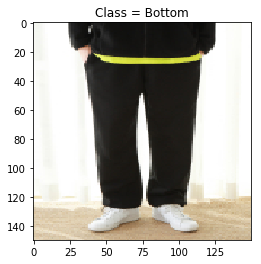

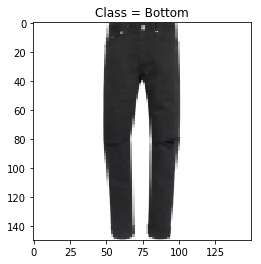

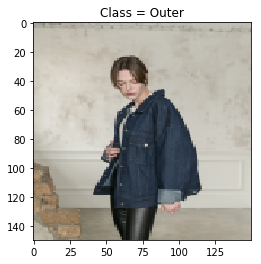

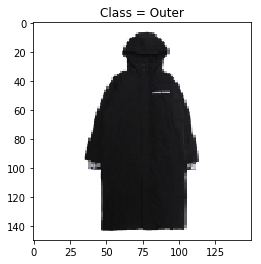

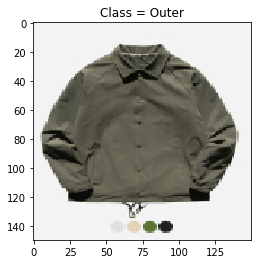

In [7]:
import PIL
from PIL import Image
from IPython.display import display


for X_batch, Y_batch in train_generator:
    for i in range(5):
        show_sample(X_batch[i, :, :, :], np.argmax(Y_batch[i]))
    break

In [8]:
def build_vgg16(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

weights_path = 'vgg16_weights.h5'
th_model = build_vgg16('th')

assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
# f = h5py.File(weights_path)
th_model.load_weights(weights_path)

# for i in f.attrs["layer_names"]:
#     print(i)
# tmp = f['block1_conv1']
# for i in tmp:
#     print(i)
# print(tmp.attrs['weight_names'])
# print(tmp['block1_conv1_W_1:0'])

# for k in range(len(f.attrs["layer_names"])):
#     if k >= len(th_model.layers):
#         # we don't look at the last (fully-connected) layers in the savefile
#         break
#     g = f['layer_{}'.format(k)]
#     weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
#     th_model.layers[k].set_weights(weights)
# f.close()
# print('Model loaded.')

tf_model = build_vgg16('tf')

for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ == 'Convolution2D':
      kernel, bias = th_layer.get_weights()
      kernel = np.transpose(kernel, (2, 3, 1, 0))
      tf_layer.set_weights([kernel, bias])
    else:
      tf_layer.set_weights(tf_layer.get_weights())
    
top_model = Sequential()
print (Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))
print (tf_model.summary())
print(top_model.summary())

/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  app.launch_new_instance()
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Kera

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14 (ZeroPaddi (None, 152, 152, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 152, 152, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 77, 77, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856     
__________

In [9]:
tf_model.add(top_model)

In [93]:
#Freezing the weights of all layers except top

for layer in tf_model.layers[:-4]:
    layer.trainable = False
    
#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
tf_model.compile(loss = 'categorical_crossentropy',
              optimizer = adam1,
              metrics=['accuracy'])

In [ ]:
#Training the model for 5 epochs

#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg_weights_frozen_pattern.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 5,
        validation_data = validation_generator,
#         nb_val_samples = nb_validation_samples,
        validation_steps=nb_validation_samples//50,
        verbose = 1,
        initial_epoch = 0,
        callbacks=[checkpoint_callback]
)

/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, initial_epoch=0, callbacks=[<keras.ca..., steps_per_epoch=44, epochs=5, validation_steps=262)`
  


Epoch 1/5
43/44 [============================>.] - ETA: 6s - loss: 1.0446 - acc: 0.4827 

In [10]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
       break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [11]:

#unfreezing the layers and recompiling the model 

for layer in tf_model.layers[:-4]:
    layer.trainable = True
    
#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
tf_model.compile(loss = 'categorical_crossentropy',
              optimizer = adam1,
              metrics=['accuracy'])

In [12]:
#Loading weights with the best validation aaccuracy
tf_model.load_weights('./models/vgg_weights_frozen_pattern.hdf5')

In [13]:
#Training the whole network for 5 epochs first
checkpoint_callback = ModelCheckpoint('./models/vgg_weights_best_pattern.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 10,
        validation_data = validation_generator,
        validation_steps=nb_validation_samples//50,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = 5,
        callbacks=[checkpoint_callback]
)

/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=5, verbose=1, initial_epoch=5, callbacks=[<keras.ca..., steps_per_epoch=44, epochs=10)`
  del sys.path[0]


Epoch 6/10
44/44 [==============================] - 848s 19s/step - loss: 0.7371 - acc: 0.6413 - val_loss: 0.5363 - val_acc: 0.7123
Epoch 7/10
44/44 [==============================] - 871s 20s/step - loss: 0.6245 - acc: 0.6959 - val_loss: 0.5588 - val_acc: 0.7480
Epoch 8/10
44/44 [==============================] - 965s 22s/step - loss: 0.5739 - acc: 0.7047 - val_loss: 0.5475 - val_acc: 0.7358
Epoch 9/10
44/44 [==============================] - 940s 21s/step - loss: 0.5527 - acc: 0.7167 - val_loss: 0.4797 - val_acc: 0.7925
Epoch 10/10
44/44 [==============================] - 879s 20s/step - loss: 0.5497 - acc: 0.7247 - val_loss: 0.4994 - val_acc: 0.7453


In [14]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
       break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.737000  ;  loss = 0.537598


In [ ]:
tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 13,
        validation_data = validation_generator,
        validation_steps=nb_validation_samples//50,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = 10,
        callbacks=[checkpoint_callback]
)

/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/home/minkj1992/anaconda3/envs/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=5, verbose=1, initial_epoch=10, callbacks=[<keras.ca..., steps_per_epoch=44, epochs=13)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 11/13
20/44 [============>.................] - ETA: 7:26 - loss: 0.4632 - acc: 0.7790